# Fashion MNIST Classification with CNN using Pytorch

### Author: Ahmed Hamza Bin Asif

#### Language: Python
#### Framework: Pytorch
#### Libraries: Numpy, Matplotlib
#### CPU: AMD Ryzen 5 3600
#### GPU: Nvidia GTX 1660 Super


### Step 0: Import Required Libraries

In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Step 1: Data Transformation

In [96]:
transforms = transforms.Compose([transforms.ToTensor()])

### Step 2: Data Collection

In [97]:
# download the dataset using torchvision.datasets.MNIST() into train and test sets
# apply the transformations to the data

trainSet = torchvision.datasets.FashionMNIST('data', train = True, download = True, transform = transforms)
testSet = torchvision.datasets.FashionMNIST('data', train = False, download = True, transform = transforms)

### Step 3: Data Loading

In [1]:
# Load the dataset into train and test set using Pytorch Dataloader
# Set the batch size to 100 for better performance
# train and test loader will be torch tensors that will contain the Image and its Label

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size = 100)
testLoader = torch.utils.data.DataLoader(testSet, batch_size = 100)

NameError: name 'torch' is not defined

### Step 4: Data Visulaization

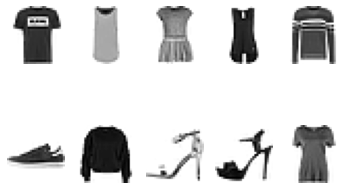

In [100]:
# iter() to create an iterator object. The object will be the training set.
# next() will be used on the iter() object to get iterate through the pictures
# img will contain the image and lbl will contain the label for that image
# use matplotlib functions to create a plot to display 120 images
# numpy.squeeze() to remove unnecessary one-dimensional entries

img, lbl = next(iter(trainLoader))
#print(type(img))
#print(type(lbl))
fig = plt.figure()
n_img = 10
for i in range(1, n_img + 1):
    plt.subplot(2, 5, i)
    plt.axis('off')
    plt.imshow(img[i].numpy().squeeze(), cmap='gray_r')

### Step 5: Convolutional Neural Network Building

In [101]:
class ConvNet(nn.Module):    
    # Contructor
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [102]:
# This part will initialize the above neural network
# The model will be intialized and will be transferred to Cuda which simply means that all of the model training and testing
# will be performed on the GPU instead of CPU for better performance 
# CUDA toolkit will be used to use the GPU 

# Initializer
device = torch.device("cuda")

model = ConvNet()

model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

### Step 6 : Hyperparameters

In [117]:
# The dataset will be iterated through 5 times during model training in order to get better performance so Epoch will be 5
# Learning rate is the rate at which our Model will perform Gradient Descent to converge to the Global Minimum
# torch.optim.Adam - Adam Optimizer will be used as the Optimizer of this model
# Loss Function is the CrossEntropyLoss

epochs = 5
learning_rate = 0.01
lossFunc = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())

### Step 7: Model Training

In [118]:
from tqdm import tqdm
def modelTrain(model, device, trainLoader, optimizer, lossFunc):
    
    pbar = tqdm(trainLoader)
    
    for batch_idx, (data, target) in enumerate(pbar):
        model.train()
        data, target = data.to(device), target.to(device)
        train = torch.autograd.Variable(data.view(100, 1, 28, 28))
        lbl = torch.autograd.Variable(target)
        output = model(train)
        optimizer.zero_grad()
        loss = lossFunc(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'epoch: {epoch} loss={loss.item()}')

In [119]:
# Train the model for 5 epochs

for epoch in range(1, epochs+1):
    modelTrain(model, device, trainLoader, optimizer, lossFunc)
    #modelTest(model, device, testLoader)

epoch: 5 loss=0.13385315239429474: 100%|█████████████████████████████████████████████| 600/600 [00:06<00:00, 91.94it/s]


### Step 8: Model Testing

In [123]:
# modeltest() function will take the neural net, device(GPU) and tests set as input parameters
# model.eval() will be called for model evaluation
# Two variables will be initialized to calculate the loss and accuracy for the test set 
# Following steps will be performed during model testing:
# 1. Gradient will be initialized to zero
# 2. In every iteration of the test data, one image and its label will taken for testing
# 3. Image will be given to the learned model for testing
# 4. Negative Log Likelihood Loss function will be used to compute the loss for the image
# 5. np.argmax() will be used to get the indices of the maximum probability tensor
# 6. Model accuracy will be calculated after summing up the tensor values and getting the element-wise equality using
# pytorch.eq() function
# 7. After complete testing the Average loss will be calculated by dividing the total loss with total number of images 
# in the dataset.
# Average Loss and model accuracy will be shown as the final output for the function

def modelTest(model, device, testLoader):
    #model = Net()
    #model.load_state_dict(torch.load(PATH))
    model.eval()
    testLoss = 0
    accurate = 0
    with torch.no_grad():
        for data, target in testLoader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #print(type(output))
            testLoss += F.nll_loss(output, target).item()
            #print(type(testLoss))
            predict = output.argmax(dim = 1, keepdim = True)
            #print(type(predict))
            accurate += predict.eq(target.view_as(predict)).sum().item()
            #print(type(accurate))
            
    testLoss /= len(testLoader.dataset)
    
    print('\nTest set') 
    print("Images Tested: {}".format(len(testLoader.dataset)))
    print('Average loss: {:.4f} \nAccuracy: {}/{} => ({:.1f}%)\n'.format(
        testLoss, accurate, len(testLoader.dataset),
        100 * (accurate / len(testLoader.dataset))))

In [124]:
modelTest(model, device, testLoader)


Test set
Images Tested: 10000
Average loss: -0.2416 
Accuracy: 8906/10000 => (89.1%)



### Step 9: Save Model

In [125]:
PATH = os.getcwd()
torch.save(model.state_dict(), os.path.join(PATH,"Model.pt"))

### References:
#### https://www.marktechpost.com/2019/07/30/introduction-to-image-classification-using-pytorch-to-classify-fashionmnist-dataset/

#### https://www.kaggle.com/pankajj/fashion-mnist-with-pytorch-93-accuracy